In [31]:
!pip install git+https://github.com/woodcrafty/PyETo.git

  Cloning https://github.com/woodcrafty/PyETo.git to /tmp/pip-req-build-byvlct4n
  Running command git clone --filter=blob:none --quiet https://github.com/woodcrafty/PyETo.git /tmp/pip-req-build-byvlct4n
  Resolved https://github.com/woodcrafty/PyETo.git to commit 79ddd88d727c7ebdad0ce26e220528d2921b66ea
  Preparing metadata (setup.py) ... done


In [32]:
import pyeto, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('chau_doc.csv')
df['date'] = pd.to_datetime(df['date'])
df['doy'] = df['date'].dt.day_of_year

In [33]:
lat = pyeto.deg2rad(10.69) #latitude for Dong Thap in radians
alt = 3 #m above the sea

In [34]:
et0_penman_monteith = []
et0_hargreaves = []
for index, row in df.iterrows():
    tmax = row['max']
    tmin = row['min']
    tmean = (tmin + tmax) / 2

    rhmean = row['humidi']
    '''
    es_tmin = pyeto.svp_from_t(tmin)
    es_tmax = pyeto.svp_from_t(tmax)
    es = (es_tmin + es_tmax) / 2 #saturation vapor pressure
    ea = (row['humidi']/100) * es #actual vapor pressure
    '''
    es = pyeto.mean_svp(tmin, tmax)
    ea = pyeto.avp_from_rhmean(pyeto.svp_from_t(tmin), pyeto.svp_from_t(tmax), rhmean)

    '''
    wind = row['wind'] * 0.278
    z = 10 #measured height
    wind_2m = 4.87/(np.log(67.8*z-5.42)) * wind
    '''
    wind_2m = pyeto.wind_speed_2m(row['wind'] * 0.278, # convert to m/s
                                  z = 10)

    delta_vs = pyeto.delta_svp(tmean) # slope vapour pressure curve (delta)

    #extraterrestrial radiation (Ra)
    et_rad = pyeto.et_rad(lat,
                          pyeto.sol_dec(row['doy']), # solar declination
                          pyeto.sunset_hour_angle(lat, pyeto.sol_dec(row['doy'])),
                          pyeto.inv_rel_dist_earth_sun(row['doy'])
                          )
    # clear sky radiation
    cs_rad = pyeto.cs_rad(alt, et_rad)

    # incoming solar radiation (Rs)
    solar_rad = pyeto.sol_rad_from_t(et_rad, cs_rad, tmin, tmax, coastal=False)
    # net outgoing longwave
    net_out = pyeto.net_out_lw_rad(tmin+273, tmax+273, solar_rad, cs_rad, ea)
    # net incoming shortwave
    net_in = pyeto.net_in_sol_rad(solar_rad,
                                  albedo=0.23 # value for short grass crop
                                  )
    net_rad = net_in - net_out

    pressure = row['pressure']/10 #hPa to kPa
    psy = pyeto.psy_const(pressure)

    et1 = pyeto.fao56_penman_monteith(
        net_rad=net_rad,
        t=tmean,
        ws=wind_2m,
        svp = es,
        avp = ea,
        delta_svp=delta_vs,
        psy=psy,
        shf=0
    )
    et2 = pyeto.hargreaves(tmin, tmax, tmean, et_rad)

    et0_penman_monteith.append(et1)
    et0_hargreaves.append(et2)

In [35]:
df['et0_penman_monteith'] = et0_penman_monteith
df['et0_hargreaves'] = et0_hargreaves

In [36]:
df.head()

,province,max,min,wind,wind_d,rain,humidi,cloud,pressure,date,...,et0_penman_monteith,et0_hargreaves,year,month,day_of_year,difference,et0_hg_7day,et0_pm_7day,et0_hg_30day,et0_pm_30day
0,Chau Doc,25,20,17,SE,10.4,89,87,1011,2009-01-01,...,10.724588,2.606407,2009,1,1,8.118181,NaN,NaN,NaN,NaN
1,Chau Doc,27,21,22,NNE,0.1,80,49,1012,2009-01-02,...,21.496075,2.964835,2009,1,2,18.531240,NaN,NaN,NaN,NaN
2,Chau Doc,27,21,18,NNE,0.0,76,55,1012,2009-01-03,...,22.331591,2.968468,2009,1,3,19.363124,NaN,NaN,NaN,NaN
3,Chau Doc,29,21,13,NNE,0.0,71,40,1012,2009-01-04,...,21.454219,3.514277,2009,1,4,17.939942,3.367762,20.816381,NaN,NaN
4,Chau Doc,30,21,14,NNE,0.0,69,9,1011,2009-01-05,...,24.158494,3.776222,2009,1,5,20.382272,3.537373,24.087763,NaN,NaN


In [ ]:
#df.to_csv('test.csv', index=False)

Dataset: 4549 records from 2009-01-01 00:00:00 to 2021-06-18 00:00:00
Years covered: [np.int32(2009), np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]


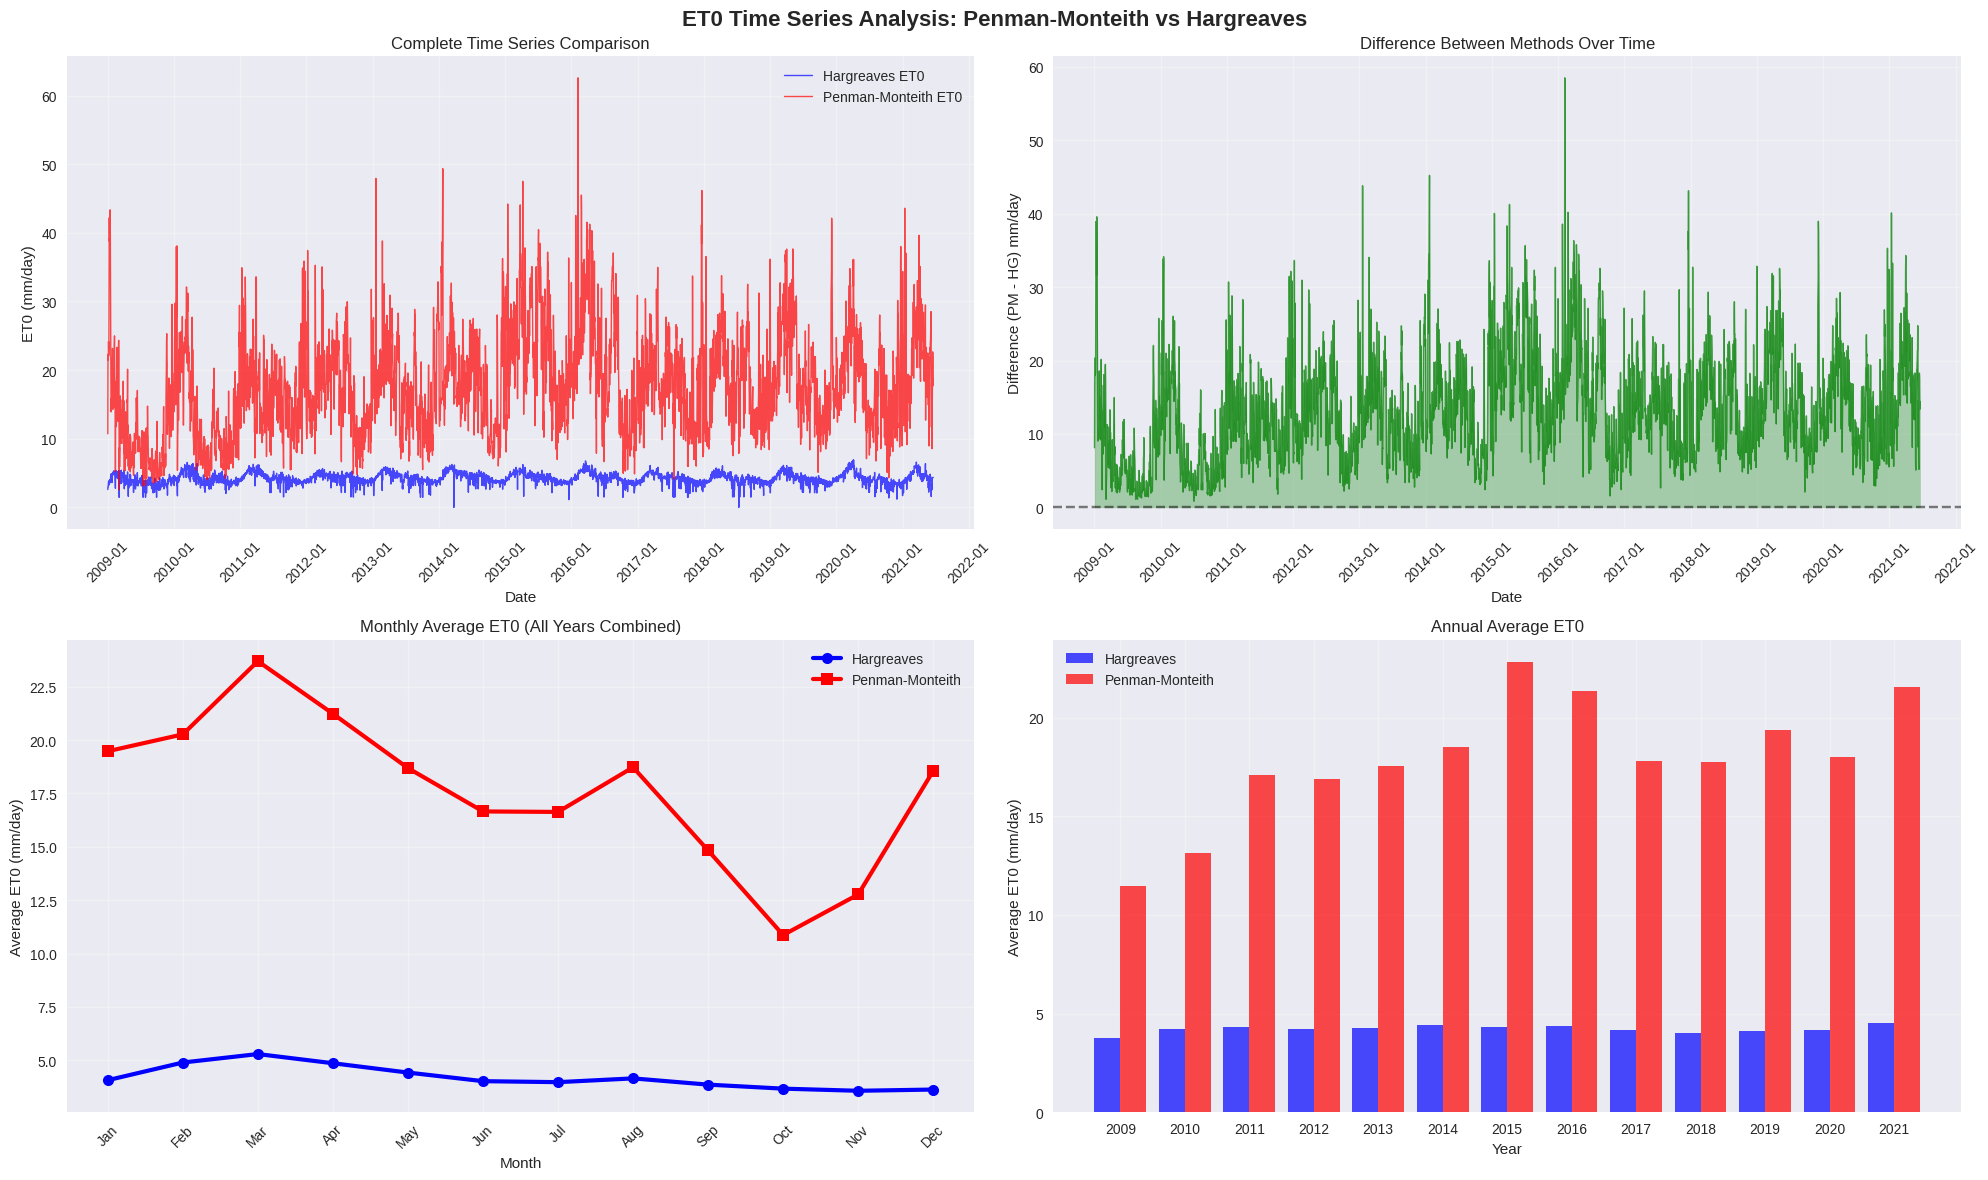

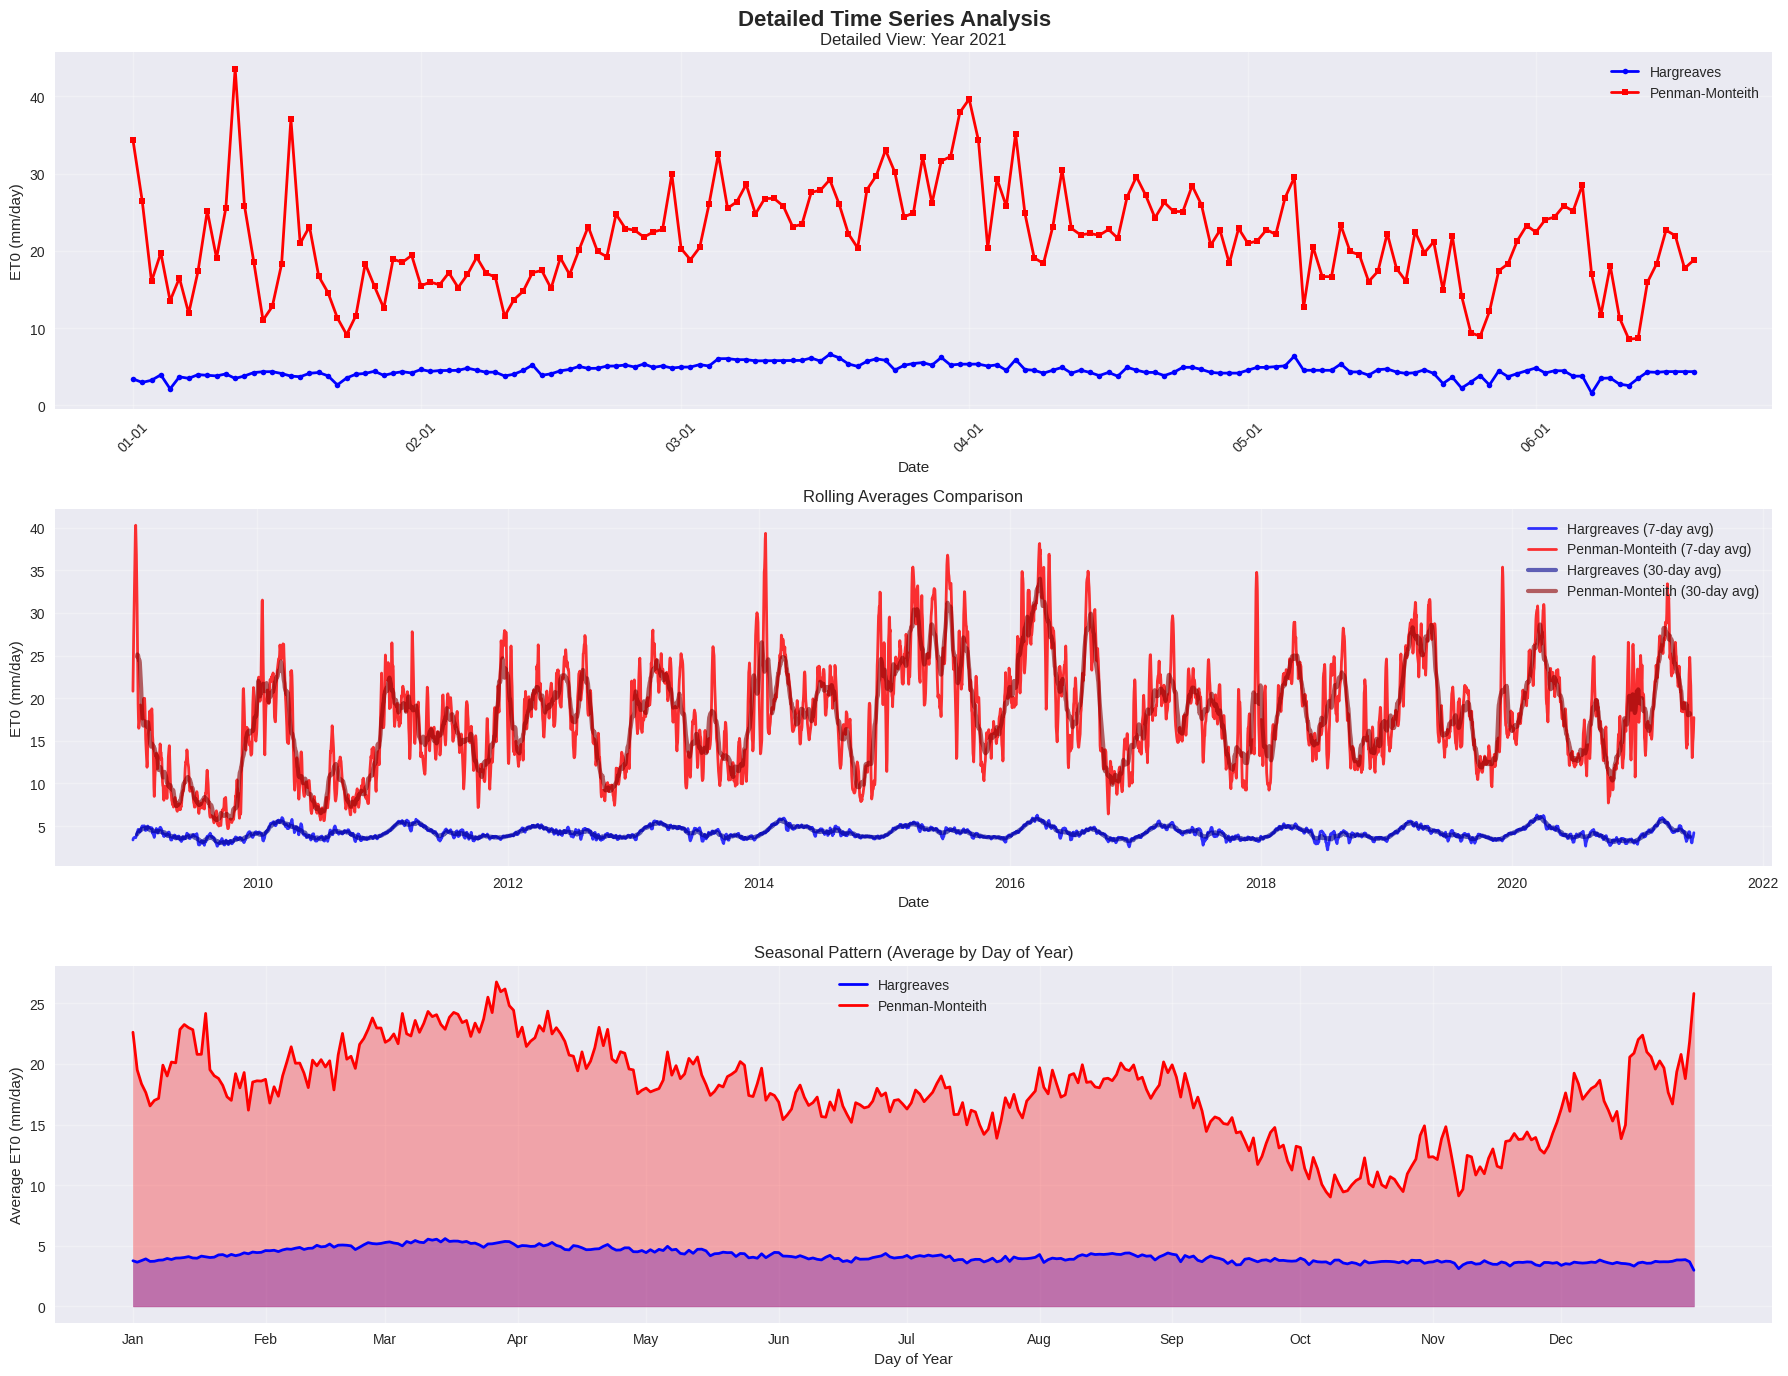


=== TIME SERIES SUMMARY ===
Data period: 2009-01-01 to 2021-06-18
Total days: 4549

Hargreaves ET0:
  Overall mean: 4.21 mm/day
  Seasonal range: 0.00 - 6.91 mm/day

Penman-Monteith ET0:
  Overall mean: 17.79 mm/day
  Seasonal range: 2.57 - 62.58 mm/day

Difference (PM - HG):
  Mean difference: 13.58 mm/day
  Range: 0.85 to 58.50 mm/day

=== MONTHLY PATTERNS ===
Month  | Hargreaves (mean±std) | Penman-Monteith (mean±std) | Difference (mean±std)
--------------------------------------------------------------------------------
 1     |   4.07± 0.48        |  19.48± 7.74          |  15.41± 7.72
 2     |   4.90± 0.49        |  20.27± 5.85          |  15.37± 5.70
 3     |   5.29± 0.68        |  23.70± 6.35          |  18.40± 5.99
 4     |   4.86± 0.67        |  21.23± 7.38          |  16.37± 7.03
 5     |   4.43± 0.61        |  18.69± 6.94          |  14.26± 6.70
 6     |   4.02± 0.72        |  16.66± 6.00          |  12.64± 5.66
 7     |   3.98± 0.76        |  16.63± 7.03          |  12.66

'\nimport plotly.graph_objects as go\nfrom plotly.subplots import make_subplots\n\n# Create interactive time series plot\nfig_interactive = make_subplots(\n    rows=2, cols=1,\n    subplot_titles=(\'ET0 Comparison\', \'Difference\'),\n    shared_xaxes=True,\n    vertical_spacing=0.1\n)\n\n# Add traces\nfig_interactive.add_trace(\n    go.Scatter(x=df[\'date\'], y=df[\'et0_hargreaves\'],\n               mode=\'lines\', name=\'Hargreaves\', line=dict(color=\'blue\')),\n    row=1, col=1\n)\nfig_interactive.add_trace(\n    go.Scatter(x=df[\'date\'], y=df[\'et0_penman_monteith\'],\n               mode=\'lines\', name=\'Penman-Monteith\', line=dict(color=\'red\')),\n    row=1, col=1\n)\nfig_interactive.add_trace(\n    go.Scatter(x=df[\'date\'], y=df[\'difference\'],\n               mode=\'lines\', name=\'Difference (PM-HG)\', line=dict(color=\'green\')),\n    row=2, col=1\n)\n\nfig_interactive.update_layout(height=600, title_text="Interactive ET0 Time Series")\nfig_interactive.update_xaxes(ti

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

# Load and prepare the data
df = pd.read_csv('test(1).csv')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear

# Calculate difference for additional analysis
df['difference'] = df['et0_penman_monteith'] - df['et0_hargreaves']

# Sort by date to ensure proper time series
df = df.sort_values('date').reset_index(drop=True)

print(f"Dataset: {len(df)} records from {df['date'].min()} to {df['date'].max()}")
print(f"Years covered: {sorted(df['year'].unique())}")

# Create comprehensive time series visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('ET0 Time Series Analysis: Penman-Monteith vs Hargreaves', fontsize=16, fontweight='bold')

# 1. Complete time series
ax1 = axes[0, 0]
ax1.plot(df['date'], df['et0_hargreaves'], label='Hargreaves ET0',
         color='blue', alpha=0.7, linewidth=1)
ax1.plot(df['date'], df['et0_penman_monteith'], label='Penman-Monteith ET0',
         color='red', alpha=0.7, linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('ET0 (mm/day)')
ax1.set_title('Complete Time Series Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. Difference time series
ax2 = axes[0, 1]
ax2.plot(df['date'], df['difference'], color='green', alpha=0.7, linewidth=1)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.fill_between(df['date'], df['difference'], 0, alpha=0.3, color='green')
ax2.set_xlabel('Date')
ax2.set_ylabel('Difference (PM - HG) mm/day')
ax2.set_title('Difference Between Methods Over Time')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.YearLocator())
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 3. Monthly averages across all years
ax3 = axes[1, 0]
monthly_avg = df.groupby('month')[['et0_hargreaves', 'et0_penman_monteith']].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = range(1, 13)
ax3.plot(x, monthly_avg['et0_hargreaves'], 'o-', label='Hargreaves',
         linewidth=3, markersize=8, color='blue')
ax3.plot(x, monthly_avg['et0_penman_monteith'], 's-', label='Penman-Monteith',
         linewidth=3, markersize=8, color='red')
ax3.set_xlabel('Month')
ax3.set_ylabel('Average ET0 (mm/day)')
ax3.set_title('Monthly Average ET0 (All Years Combined)')
ax3.set_xticks(x)
ax3.set_xticklabels(month_names, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Annual averages
ax4 = axes[1, 1]
yearly_avg = df.groupby('year')[['et0_hargreaves', 'et0_penman_monteith']].mean()
years = yearly_avg.index
ax4.bar(years - 0.2, yearly_avg['et0_hargreaves'], width=0.4,
        label='Hargreaves', alpha=0.7, color='blue')
ax4.bar(years + 0.2, yearly_avg['et0_penman_monteith'], width=0.4,
        label='Penman-Monteith', alpha=0.7, color='red')
ax4.set_xlabel('Year')
ax4.set_ylabel('Average ET0 (mm/day)')
ax4.set_title('Annual Average ET0')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xticks(years)

plt.tight_layout()
plt.savefig('et0_timeseries_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional detailed time series plots
fig2, axes2 = plt.subplots(3, 1, figsize=(18, 14))
fig2.suptitle('Detailed Time Series Analysis', fontsize=16, fontweight='bold')

# 1. Focus on one year (if multiple years available)
if len(df['year'].unique()) > 1:
    # Take the most recent complete year
    latest_year = df['year'].max()
    df_year = df[df['year'] == latest_year].copy()

    ax_year = axes2[0]
    ax_year.plot(df_year['date'], df_year['et0_hargreaves'], 'o-',
                label='Hargreaves', linewidth=2, markersize=4, color='blue')
    ax_year.plot(df_year['date'], df_year['et0_penman_monteith'], 's-',
                label='Penman-Monteith', linewidth=2, markersize=4, color='red')
    ax_year.set_xlabel('Date')
    ax_year.set_ylabel('ET0 (mm/day)')
    ax_year.set_title(f'Detailed View: Year {latest_year}')
    ax_year.legend()
    ax_year.grid(True, alpha=0.3)
    ax_year.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax_year.xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(ax_year.xaxis.get_majorticklabels(), rotation=45)
else:
    # If only one year, show all data with more detail
    ax_year = axes2[0]
    ax_year.plot(df['date'], df['et0_hargreaves'], 'o-',
                label='Hargreaves', linewidth=2, markersize=3, color='blue')
    ax_year.plot(df['date'], df['et0_penman_monteith'], 's-',
                label='Penman-Monteith', linewidth=2, markersize=3, color='red')
    ax_year.set_xlabel('Date')
    ax_year.set_ylabel('ET0 (mm/day)')
    ax_year.set_title('Detailed Time Series View')
    ax_year.legend()
    ax_year.grid(True, alpha=0.3)

# 2. Rolling averages (7-day and 30-day)
ax_rolling = axes2[1]
df['et0_hg_7day'] = df['et0_hargreaves'].rolling(window=7, center=True).mean()
df['et0_pm_7day'] = df['et0_penman_monteith'].rolling(window=7, center=True).mean()
df['et0_hg_30day'] = df['et0_hargreaves'].rolling(window=30, center=True).mean()
df['et0_pm_30day'] = df['et0_penman_monteith'].rolling(window=30, center=True).mean()

ax_rolling.plot(df['date'], df['et0_hg_7day'], label='Hargreaves (7-day avg)',
               linewidth=2, color='blue', alpha=0.8)
ax_rolling.plot(df['date'], df['et0_pm_7day'], label='Penman-Monteith (7-day avg)',
               linewidth=2, color='red', alpha=0.8)
ax_rolling.plot(df['date'], df['et0_hg_30day'], label='Hargreaves (30-day avg)',
               linewidth=3, color='darkblue', alpha=0.6)
ax_rolling.plot(df['date'], df['et0_pm_30day'], label='Penman-Monteith (30-day avg)',
               linewidth=3, color='darkred', alpha=0.6)
ax_rolling.set_xlabel('Date')
ax_rolling.set_ylabel('ET0 (mm/day)')
ax_rolling.set_title('Rolling Averages Comparison')
ax_rolling.legend()
ax_rolling.grid(True, alpha=0.3)

# 3. Seasonal patterns (day of year)
ax_seasonal = axes2[2]
# Group by day of year and calculate mean
seasonal_pattern = df.groupby('day_of_year')[['et0_hargreaves', 'et0_penman_monteith']].mean()
day_of_year = seasonal_pattern.index

ax_seasonal.plot(day_of_year, seasonal_pattern['et0_hargreaves'],
                label='Hargreaves', linewidth=2, color='blue')
ax_seasonal.plot(day_of_year, seasonal_pattern['et0_penman_monteith'],
                label='Penman-Monteith', linewidth=2, color='red')
ax_seasonal.fill_between(day_of_year, seasonal_pattern['et0_hargreaves'],
                        alpha=0.3, color='blue')
ax_seasonal.fill_between(day_of_year, seasonal_pattern['et0_penman_monteith'],
                        alpha=0.3, color='red')
ax_seasonal.set_xlabel('Day of Year')
ax_seasonal.set_ylabel('Average ET0 (mm/day)')
ax_seasonal.set_title('Seasonal Pattern (Average by Day of Year)')
ax_seasonal.legend()
ax_seasonal.grid(True, alpha=0.3)

# Add month markers
month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax_seasonal.set_xticks(month_starts)
ax_seasonal.set_xticklabels(month_labels)

plt.tight_layout()
plt.savefig('et0_detailed_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== TIME SERIES SUMMARY ===")
print(f"Data period: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"Total days: {len(df)}")

print(f"\nHargreaves ET0:")
print(f"  Overall mean: {df['et0_hargreaves'].mean():.2f} mm/day")
print(f"  Seasonal range: {df['et0_hargreaves'].min():.2f} - {df['et0_hargreaves'].max():.2f} mm/day")

print(f"\nPenman-Monteith ET0:")
print(f"  Overall mean: {df['et0_penman_monteith'].mean():.2f} mm/day")
print(f"  Seasonal range: {df['et0_penman_monteith'].min():.2f} - {df['et0_penman_monteith'].max():.2f} mm/day")

print(f"\nDifference (PM - HG):")
print(f"  Mean difference: {df['difference'].mean():.2f} mm/day")
print(f"  Range: {df['difference'].min():.2f} to {df['difference'].max():.2f} mm/day")

# Monthly statistics
print(f"\n=== MONTHLY PATTERNS ===")
monthly_stats = df.groupby('month')[['et0_hargreaves', 'et0_penman_monteith', 'difference']].agg(['mean', 'std'])
print("Month  | Hargreaves (mean±std) | Penman-Monteith (mean±std) | Difference (mean±std)")
print("-" * 80)
for month in range(1, 13):
    if month in monthly_stats.index:
        hg_mean = monthly_stats.loc[month, ('et0_hargreaves', 'mean')]
        hg_std = monthly_stats.loc[month, ('et0_hargreaves', 'std')]
        pm_mean = monthly_stats.loc[month, ('et0_penman_monteith', 'mean')]
        pm_std = monthly_stats.loc[month, ('et0_penman_monteith', 'std')]
        diff_mean = monthly_stats.loc[month, ('difference', 'mean')]
        diff_std = monthly_stats.loc[month, ('difference', 'std')]

        print(f"{month:2d}     | {hg_mean:6.2f}±{hg_std:5.2f}        | {pm_mean:6.2f}±{pm_std:5.2f}          | {diff_mean:6.2f}±{diff_std:5.2f}")

# Save processed data with time series features
df_export = df[['date', 'year', 'month', 'day_of_year', 'et0_hargreaves', 'et0_penman_monteith',
               'difference', 'et0_hg_7day', 'et0_pm_7day', 'et0_hg_30day', 'et0_pm_30day']].copy()
df_export.to_csv('et0_timeseries_data.csv', index=False)
print(f"\nTime series data exported to 'et0_timeseries_data.csv'")

# Interactive plot option (uncomment if using Jupyter or supporting environment)
"""
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create interactive time series plot
fig_interactive = make_subplots(
    rows=2, cols=1,
    subplot_titles=('ET0 Comparison', 'Difference'),
    shared_xaxes=True,
    vertical_spacing=0.1
)

# Add traces
fig_interactive.add_trace(
    go.Scatter(x=df['date'], y=df['et0_hargreaves'],
               mode='lines', name='Hargreaves', line=dict(color='blue')),
    row=1, col=1
)
fig_interactive.add_trace(
    go.Scatter(x=df['date'], y=df['et0_penman_monteith'],
               mode='lines', name='Penman-Monteith', line=dict(color='red')),
    row=1, col=1
)
fig_interactive.add_trace(
    go.Scatter(x=df['date'], y=df['difference'],
               mode='lines', name='Difference (PM-HG)', line=dict(color='green')),
    row=2, col=1
)

fig_interactive.update_layout(height=600, title_text="Interactive ET0 Time Series")
fig_interactive.update_xaxes(title_text="Date", row=2, col=1)
fig_interactive.update_yaxes(title_text="ET0 (mm/day)", row=1, col=1)
fig_interactive.update_yaxes(title_text="Difference (mm/day)", row=2, col=1)

fig_interactive.show()
"""